# Generating images with DDPMs: A PyTorch Implementation

Denoise Diffusion Probabilistic Models (DDPMs) are generative models based on the idea of reversing a noising process. The idea is fairly simple: Given a dataset, make it more and more noisy with a deterministic process. Then, learn a model that can undo this process.

DDPM-based models have recently drawn a lot of attention due to their high-quality samples. In this notebook, I re-implement the first and most fundamental paper to be familiar with when dealing with DDPMs: <i>Denoising Diffusion Probabilistic Models</i> (https://arxiv.org/pdf/2006.11239.pdf) by Ho et. al.

**Check out the GitHub Repository** (https://github.com/BrianPulfer/PapersReimplementations/tree/master/ddpm) to get .py files that you can use in other projects.

# Author


<img src="https://www.brianpulfer.ch/static/media/avatar.54e9184eb33043f0169a.png" alt="Picture of Brian Pulfer" width="400"/> <br/>
**Brian Pulfer** <br/>
[🌐 Website](https://www.brianpulfer.ch) [🐦 Twitter](https://twitter.com/PulferBrian21), [🧑🏽‍💻 GitHub](https://github.com/BrianPulfer), [👔 LinekdIn](https://www.linkedin.com/in/BrianPulfer/)<br/>
University of Geneva <br/>
Stochastic Information Processing Group <br/>
<br/>
Last modified: <i>15.12.2022</i>

# Installs

The only package we will need is the **einops** package. This will be used to create a nice GIF animation of our DDPM model.

In [1]:
!pip3 install --upgrade pip
!pip3 install einops

/bin/bash: /home/gil/anaconda3/envs/LeeYS/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/gil/anaconda3/envs/LeeYS/lib/libtinfo.so.6: no version information available (required by /bin/bash)


# Imports and Definitions

In [2]:
# Import of libraries
import random
import imageio
import numpy as np
import math
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import einops
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import Compose, ToTensor, Lambda

import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from glob import glob
from PIL import Image
# Setting reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Definitions
STORE_PATH_MNIST = f"ddpm_model_mnist.pt"
STORE_PATH_FASHION = f"ddpm_model_fashion.pt"

## Execution options

Here's a few options you should set:

 - `no_train` specifies whether you want to skip the training loop and just use a pre-trained model. If you haven't trained a model already using this notebook, keep this as `False`. If you want to use a pre-trained model, load it in the colab filesystem.

- `fashion` specifies whether you want to use the Fashion-MNIST dataset (`True`) or not and use the MNIST dataset instead (`False`).

- `batch_size`, `n_epochs` and `lr` are your typical training hyper-parameters. Notice that `lr=0.001` is the hyper-parameter used by the authors.


In [26]:

params={'image_size':128,
        'lr':2e-4,
        'batch_size':32,
        'epochs':10000,
        'data_path':'../../data/dataset/colon_all/',
        'n_step':1000}
class ModelConfig:
    BASE_CH = 128  # 128, 256, 256, 512, 512
    BASE_CH_MULT = (1, 2, 2, 4, 4) # 128, 64, 32, 16, 8
    APPLY_ATTENTION = (False, False, False, True, False)
    DROPOUT_RATE = 0.1
    TIME_EMB_MULT = 4 # 128

In [4]:
store_path = "../../model/DDPM/ddpm_colon.pt"

# Utility functions

Following are two utility functions: `show_images` allows to display images in a square-like pattern with a custom title, while `show_fist_batch` simply shows the images in the first batch of a DataLoader object.

In [5]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()
        images=np.transpose(images, (0,2, 3, 1))
        images=images-images.min()
        images=images/images.max()
    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx])
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()

In [6]:
def show_first_batch(loader):
    for batch in loader:
        show_images(batch, "Images in the first batch")
        break

## Loading data
We will use the MNIST (or FashionMNIST) dataset and try to generate some new samples out of (nowhere, but starting from some) random gaussian noise. **NOTE**: It is important to normalize images in range `[-1,1]` and not `[0,1]` as one might usually do. This is because the DDPM network predicts normally distributed noises throughout the denoising process.

In [7]:
# Loading the data (converting each image into a tensor and normalizing between [-1, 1])
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)
class CustomDataset(Dataset):
    def __init__(self, args,dataset):
        super(Dataset, self).__init__()
        self.w = self.h = args['image_size']

        # image and mask
        self.image_path =glob(args['data_path']+dataset+'/image/*.png')
        self.trans_1 = transforms.Compose(
            [
                transforms.Resize((args['image_size'],args['image_size']), interpolation=transforms.InterpolationMode.NEAREST)
            ]
        )
    def trans(self,image_t,a):
        image_t=F.to_tensor(F.rotate(self.trans_1(image_t),a))
        return image_t

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, index):
        # load image
        image = Image.open(self.image_path[index])
        # augment
        angle=random.randint(0, 360)
        
        image = self.trans_1(F.to_tensor(image)) * 2.0 - 1.0
        
        return image
    
train_dataset=CustomDataset(params,'all')
loader = DataLoader(train_dataset, params['batch_size'], shuffle=True)

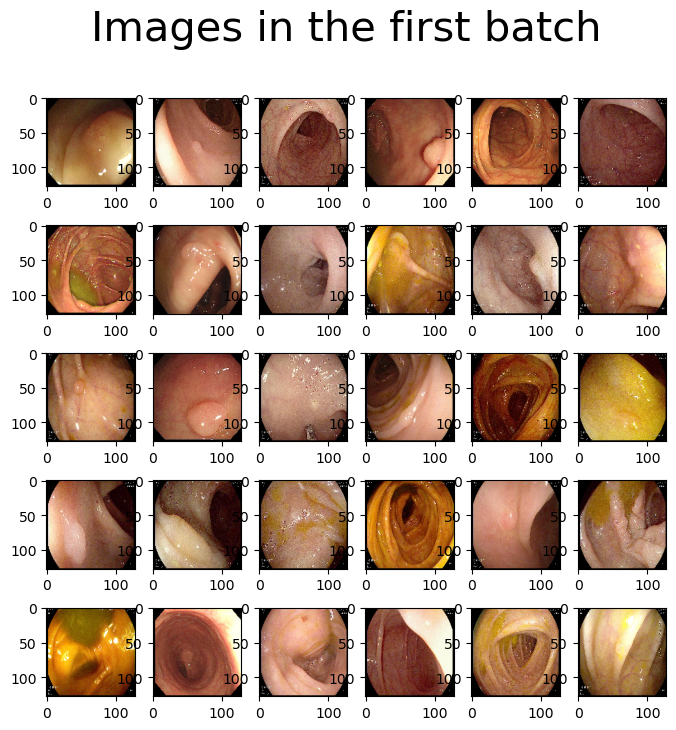

In [8]:
# Optionally, show a batch of regular images
show_first_batch(loader)

## Getting device

If you are running this codebook from Google Colab, make sure you are using a GPU runtime. For non-pro users, typically a *Tesla T4* GPU is provided.

In [9]:
# Getting device
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

Using device: cuda:3	NVIDIA A100-PCIE-40GB


# Defining the DDPM module

We now proceed and define a DDPM PyTorch module. Since in principle the DDPM scheme is independent of the model architecture used in each denoising step, we define a high-level model that is constructed using a `network` parameter, as well as:

- `n_steps`: number of diffusion steps $T$;
- `min_beta`: value of the first $\beta_t$ ($\beta_1$);
- `max_beta`: value of the last  $\beta_t$ ($\beta_T$);
- `device`: device onto which the model is run;
- `image_chw`: tuple contining dimensionality of images.

The `forward` process of DDPMs benefits from a nice property: We don't actually need to slowly add noise step-by-step, but we can directly skip to whathever step $t$ we want using coefficients $\alpha_bar$.

For the `backward` method instead, we simply let the network do the job.

Note that in this implementation, $t$ is assumed to be a `(N, 1)` tensor, where `N` is the number of images in tensor `x`. We thus support different time-steps for multiple images.

In [10]:
# DDPM class
class MyDDPM(nn.Module):
    def __init__(self, network, n_steps=200, min_beta=10 ** -4, max_beta=0.02, device=None, image_chw=(3, 128, 28)):
        super(MyDDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device)  # Number of steps is typically in the order of thousands
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, x0, t, eta=None):
        # Make input image more noisy (we can directly skip to the desired step)
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)

        noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
        return noisy

    def backward(self, x, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added.
        return self.network(x, t)

## Visualizing forward and backward

Now that we have defined the high-level functioning of a DDPM model, we can already define some related utility functions.

In particular, we will be showing the forward process (which is independent of the denoising network) with the `show_forward` method.

We run the backward pass and generate new images with the `generate_new_images` method, but this time we will put more effort into the function and also make it such that a GIF image is created. Notice that in the paper (https://arxiv.org/pdf/2006.11239.pdf) by Ho et. al., two options are considered for $\sigma_t^2$:

- $\sigma_t^2$ = $\beta_t$
- $\sigma_t^2$ = $\frac{1 - \bar{\alpha_{t-1}}}{1 - \bar{\alpha_{t}}} \beta_t$

In this implementation, they are both a few line-comments away. However, the two terms are rougly always the same and little difference is noticeable. By default, I choose the first option out of simplicity.

In [11]:
def show_forward(ddpm, loader, device):
    # Showing the forward process
    for batch in loader:
        imgs = batch

        show_images(imgs, "Original images")

        for percent in [0.25, 0.5, 0.75, 1]:
            show_images(
                ddpm(imgs.to(device),
                     [int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))]),
                f"DDPM Noisy images {int(percent * 100)}%"
            )
        break

In [12]:
def generate_new_images(ddpm, n_samples=16, device=None, frames_per_gif=100, gif_name="sampling.gif", c=3, h=128, w=128):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""
    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)
    frames = []

    with torch.no_grad():
        if device is None:
            device = ddpm.device

        # Starting from random noise
        x = torch.randn(n_samples, c, h, w).to(device)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)

                # Option 1: sigma_t squared = beta_t
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                # Option 2: sigma_t squared = beta_tilda_t
                # prev_alpha_t_bar = ddpm.alpha_bars[t-1] if t > 0 else ddpm.alphas[0]
                # beta_tilda_t = ((1 - prev_alpha_t_bar)/(1 - alpha_t_bar)) * beta_t
                # sigma_t = beta_tilda_t.sqrt()

                # Adding some more noise like in Langevin Dynamics fashion
                x = x + sigma_t * z

            # Adding frames to the GIF
            if idx in frame_idxs or t == 0:
                # Putting digits in range [0, 255]
                normalized = x.clone()
                for i in range(len(normalized)):
                    normalized[i] -= torch.min(normalized[i])
                    normalized[i] *= 255 / torch.max(normalized[i])
                    
                # Reshaping batch (n, c, h, w) to be a (as much as it gets) square frame
                frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(n_samples ** 0.5))
                frame = frame.cpu().numpy().astype(np.uint8)
                
                # Rendering frame
                frames.append(frame)
    # Storing the gif
    with imageio.get_writer(gif_name, mode="I") as writer:
        for idx, frame in enumerate(frames):
            rgb_frame = frame
            writer.append_data(rgb_frame)

            # Showing the last frame for a longer time
            if idx == len(frames) - 1:
                last_rgb_frame = frames[-1]
                for _ in range(frames_per_gif // 3):
                    writer.append_data(last_rgb_frame)
    return x

# UNet architecture

Okay great! All that concerns DDPM is down on the table already. So now we simply define an architecture that will be responsible of denoising the we should be good to go... Not so fast! While in principle that's true, we have to be careful to conditioning our model with the temporal information.

Remember that the only term of the loss function that we really care about is $||\epsilon - \epsilon_\theta(\sqrt{\bar{\alpha}_t}x_0 + \sqrt{1 - \bar{\alpha}_t}\epsilon, t)||^2$, where $\epsilon$ is some random noise and $\epsilon_\theta$ is the model's prediction of the noise. Now, $\epsilon_\theta$ is a function of both $x$ and $t$ and we don't want to have a distinct model for each denoising step (thousands of independent models), but instead we want to use a single model that takes as input the image $x$ and the scalar value indicating the timestep $t$.

To do so, in practice we use a sinusoidal embedding (function `sinusoidal_embedding`) that maps each time-step to a `time_emb_dim` dimension. These time embeddings are further mapped with some time-embedding MLPs (function `_make_te`) and added to tensors through the network in a channel-wise manner.

**NOTE:** This UNet architecture is purely arbitrary and was desined to work with 28x28 spatial resolution images.

In [13]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1))
    embedding[:,::2] = torch.sin(t * wk[:,::2])
    embedding[:,1::2] = torch.cos(t * wk[:,::2])

    return embedding

In [15]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, total_time_steps=1000, time_emb_dims=128, time_emb_dims_exp=512):
        super().__init__()

        half_dim = time_emb_dims // 2

        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)

        ts = torch.arange(total_time_steps, dtype=torch.float32)

        emb = torch.unsqueeze(ts, dim=-1) * torch.unsqueeze(emb, dim=0)
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)

        self.time_blocks = nn.Sequential(
            nn.Embedding.from_pretrained(emb),
            nn.Linear(in_features=time_emb_dims, out_features=time_emb_dims_exp),
            nn.SiLU(),
            nn.Linear(in_features=time_emb_dims_exp, out_features=time_emb_dims_exp),
        )

    def forward(self, time):
        return self.time_blocks(time)

class AttentionBlock(nn.Module):
    def __init__(self, channels=64):
        super().__init__()
        self.channels = channels

        self.group_norm = nn.GroupNorm(num_groups=8, num_channels=channels)
        self.mhsa = nn.MultiheadAttention(embed_dim=self.channels, num_heads=4, batch_first=True)

    def forward(self, x):
        B, _, H, W = x.shape
        h = self.group_norm(x)
        h = h.reshape(B, self.channels, H * W).swapaxes(1, 2)  # [B, C, H, W] --> [B, C, H * W] --> [B, H*W, C]
        h, _ = self.mhsa(h, h, h)  # [B, H*W, C]
        h = h.swapaxes(2, 1).view(B, self.channels, H, W)  # [B, C, H*W] --> [B, C, H, W]
        return x + h

class ResnetBlock(nn.Module):
    def __init__(self, *, in_channels, out_channels, dropout_rate=0.1, time_emb_dims=512, apply_attention=False):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.act_fn = nn.SiLU()
        # Group 1
        self.normlize_1 = nn.GroupNorm(num_groups=8, num_channels=self.in_channels)
        self.conv_1 = nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=3, stride=1, padding="same")

        # Group 2 time embedding
        self.dense_1 = nn.Linear(in_features=time_emb_dims, out_features=self.out_channels)

        # Group 3
        self.normlize_2 = nn.GroupNorm(num_groups=8, num_channels=self.out_channels)
        self.dropout = nn.Dropout2d(p=dropout_rate)
        self.conv_2 = nn.Conv2d(in_channels=self.out_channels, out_channels=self.out_channels, kernel_size=3, stride=1, padding="same")

        if self.in_channels != self.out_channels:
            self.match_input = nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=1, stride=1)
        else:
            self.match_input = nn.Identity()

        if apply_attention:
            self.attention = AttentionBlock(channels=self.out_channels)
        else:
            self.attention = nn.Identity()

    def forward(self, x, t):
        # group 1
        h = self.act_fn(self.normlize_1(x))
        h = self.conv_1(h)

        # group 2
        # add in timestep embedding
        h += self.dense_1(self.act_fn(t))[:, :, None, None]

        # group 3
        h = self.act_fn(self.normlize_2(h))
        h = self.dropout(h)
        h = self.conv_2(h)

        # Residual and attention
        h = h + self.match_input(x)
        h = self.attention(h)
        
        return h

class DownSample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.downsample = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, stride=2, padding=1)

    def forward(self, x, *args):
        return self.downsample(x)

class UpSample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, stride=1, padding="same")
        )

    def forward(self, x, *args):
        return self.upsample(x)

class MyUNet(nn.Module):
    def __init__(
        self,
        input_channels=3,
        output_channels=3,
        num_res_blocks=2,
        base_channels=128,
        base_channels_multiples=(1, 2, 4, 8),
        apply_attention=(False, False, True, False),
        dropout_rate=0.1,
        time_multiple=4,
    ):
        super().__init__()

        time_emb_dims_exp = base_channels * time_multiple
        self.time_embeddings = SinusoidalPositionEmbeddings(time_emb_dims=base_channels, time_emb_dims_exp=time_emb_dims_exp)

        self.first = nn.Conv2d(in_channels=input_channels, out_channels=base_channels, kernel_size=3, stride=1, padding="same")

        num_resolutions = len(base_channels_multiples)

        # Encoder part of the UNet. Dimension reduction.
        self.encoder_blocks = nn.ModuleList()
        curr_channels = [base_channels]
        in_channels = base_channels

        for level in range(num_resolutions):
            out_channels = base_channels * base_channels_multiples[level]

            for _ in range(num_res_blocks):

                block = ResnetBlock(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=apply_attention[level],
                )
                self.encoder_blocks.append(block)
                
                in_channels = out_channels
                curr_channels.append(in_channels)

            if level != (num_resolutions - 1):
                self.encoder_blocks.append(DownSample(channels=in_channels))
                curr_channels.append(in_channels)

        # Bottleneck in between
        self.bottleneck_blocks = nn.ModuleList(
            (
                ResnetBlock(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=True,
                ),
                ResnetBlock(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=False,
                ),
            )
        )

        # Decoder part of the UNet. Dimension restoration with skip-connections.
        self.decoder_blocks = nn.ModuleList()

        for level in reversed(range(num_resolutions)):
            out_channels = base_channels * base_channels_multiples[level]

            for _ in range(num_res_blocks + 1):
                encoder_in_channels = curr_channels.pop()
                block = ResnetBlock(
                    in_channels=encoder_in_channels + in_channels,
                    out_channels=out_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=apply_attention[level],
                )

                in_channels = out_channels
                self.decoder_blocks.append(block)

            if level != 0:
                self.decoder_blocks.append(UpSample(in_channels))

        self.final = nn.Sequential(
            nn.GroupNorm(num_groups=8, num_channels=in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels=in_channels, out_channels=output_channels, kernel_size=3, stride=1, padding="same"),
        )

    def forward(self, x, t):
        time_emb = self.time_embeddings(t)

        h = self.first(x)
        outs = [h]

        for layer in self.encoder_blocks:
            h = layer(h, time_emb)
            outs.append(h)

        for layer in self.bottleneck_blocks:
            h = layer(h, time_emb)

        for layer in self.decoder_blocks:
            if isinstance(layer, ResnetBlock):
                out = outs.pop()
                h = torch.cat([h, out], dim=1)
            h = layer(h, time_emb)

        h = self.final(h)

        return h

In [27]:
import pytorch_model_summary as tms
tms.summary(MyUNet(
    input_channels          = 3,
    output_channels         = 3,
    base_channels           = ModelConfig.BASE_CH,
    base_channels_multiples = ModelConfig.BASE_CH_MULT,
    apply_attention         = ModelConfig.APPLY_ATTENTION,
    dropout_rate            = ModelConfig.DROPOUT_RATE,
    time_multiple           = ModelConfig.TIME_EMB_MULT,
), torch.zeros(1, 3, 128, 128),torch.randint(0, 300, (1,)), show_input=False,print_summary=True)

-----------------------------------------------------------------------------------------
                     Layer (type)           Output Shape         Param #     Tr. Param #
   SinusoidalPositionEmbeddings-1               [1, 512]         456,704         328,704
                         Conv2d-2     [1, 128, 128, 128]           3,584           3,584
                    ResnetBlock-3     [1, 128, 128, 128]         361,344         361,344
                    ResnetBlock-4     [1, 128, 128, 128]         361,344         361,344
                     DownSample-5       [1, 128, 64, 64]         147,584         147,584
                    ResnetBlock-6       [1, 256, 64, 64]       1,050,368       1,050,368
                    ResnetBlock-7       [1, 256, 64, 64]       1,312,512       1,312,512
                     DownSample-8       [1, 256, 32, 32]         590,080         590,080
                    ResnetBlock-9       [1, 256, 32, 32]       1,312,512       1,312,512
                   R

'-----------------------------------------------------------------------------------------\n                     Layer (type)           Output Shape         Param #     Tr. Param #\n=========================================================================================\n   SinusoidalPositionEmbeddings-1               [1, 512]         456,704         328,704\n                         Conv2d-2     [1, 128, 128, 128]           3,584           3,584\n                    ResnetBlock-3     [1, 128, 128, 128]         361,344         361,344\n                    ResnetBlock-4     [1, 128, 128, 128]         361,344         361,344\n                     DownSample-5       [1, 128, 64, 64]         147,584         147,584\n                    ResnetBlock-6       [1, 256, 64, 64]       1,050,368       1,050,368\n                    ResnetBlock-7       [1, 256, 64, 64]       1,312,512       1,312,512\n                     DownSample-8       [1, 256, 32, 32]         590,080         590,080\n       

# Instantiating the model

We are finally done! Now we simply need to instantiate a model, optionally play a bit with it (show forward and backward processes) and write the usual code that defines a training loop for our model. When the model will be done training, we will test it's generative capabilities.

In [29]:
# Defining model
min_beta, max_beta =  10 ** -4, 0.02  # Originally used by the authors
ddpm = MyDDPM(MyUNet(
    input_channels          = 3,
    output_channels         = 3,
    base_channels           = ModelConfig.BASE_CH,
    base_channels_multiples = ModelConfig.BASE_CH_MULT,
    apply_attention         = ModelConfig.APPLY_ATTENTION,
    dropout_rate            = ModelConfig.DROPOUT_RATE,
    time_multiple           = ModelConfig.TIME_EMB_MULT,
), n_steps=params['n_step'], min_beta=min_beta, max_beta=max_beta, device=device)

In [18]:
sum([p.numel() for p in ddpm.parameters()])

232717187

# Optional visualizations

In [19]:
# Optionally, load a pre-trained model that will be further trained
# ddpm.load_state_dict(torch.load(store_path, map_location=device))

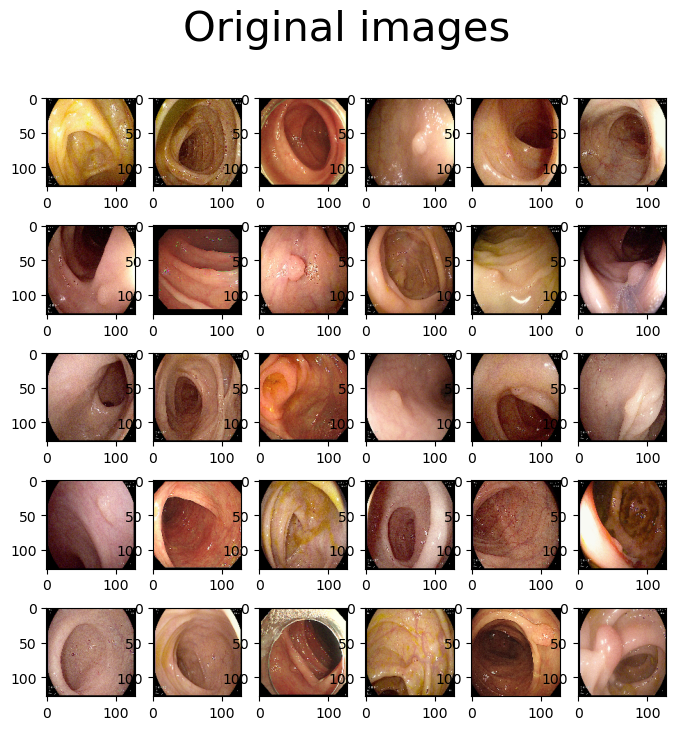

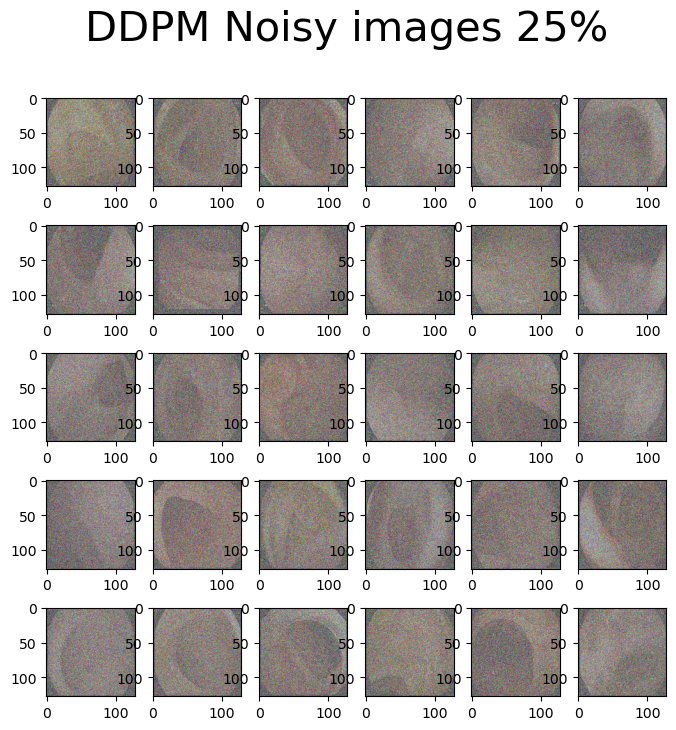

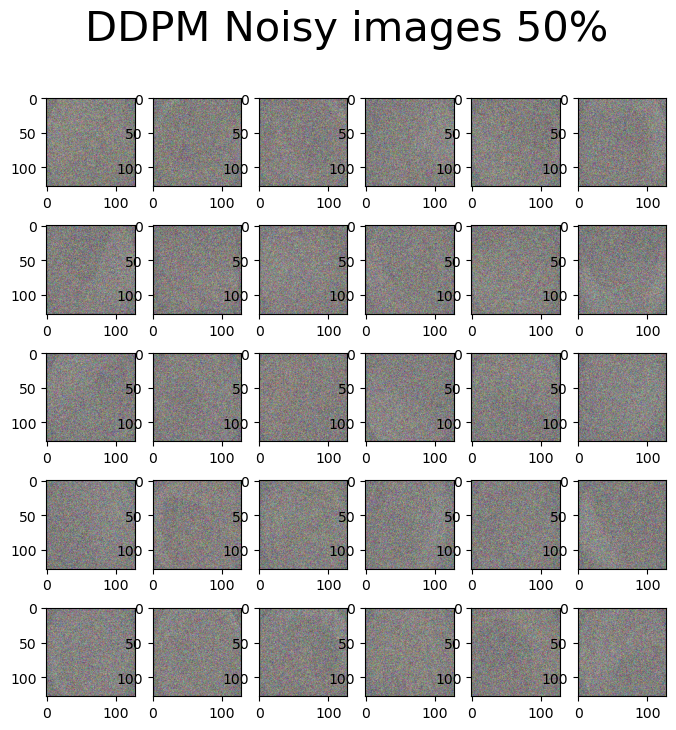

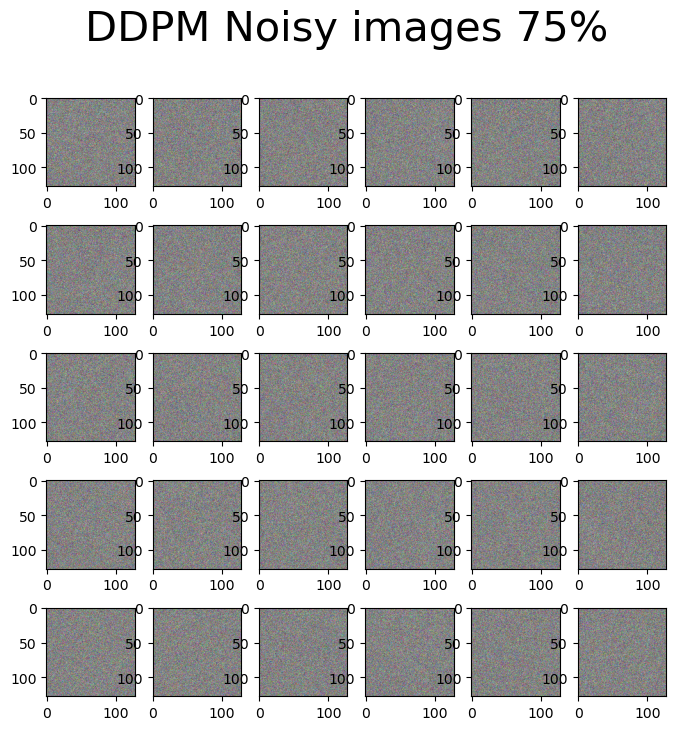

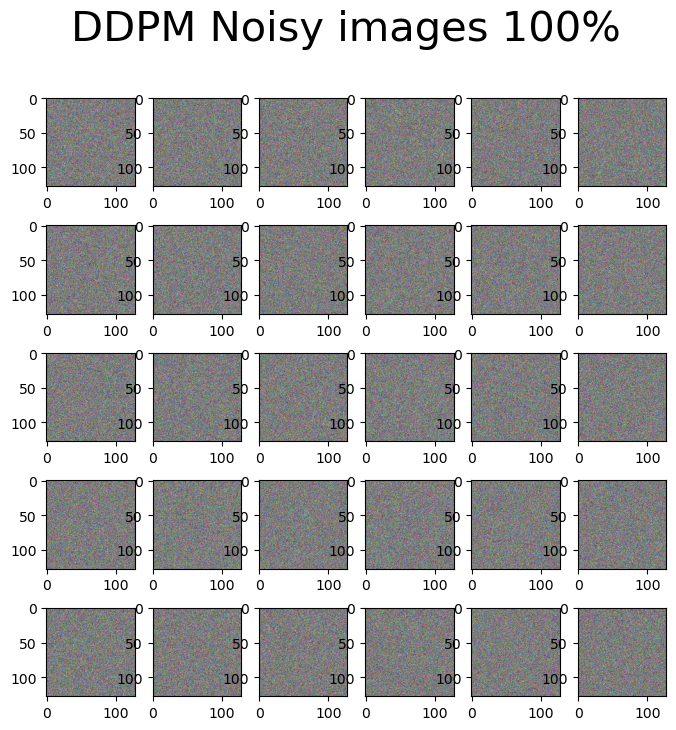

In [20]:
# Optionally, show the diffusion (forward) process
show_forward(ddpm, loader, device)

In [21]:
# Optionally, show the denoising (backward) process
generated = generate_new_images(ddpm, gif_name="../../data/colon/before_training.gif")
show_images(generated, "Images generated before training")

RuntimeError: Given groups=1, weight of size [128, 1000, 3, 3], expected input[16, 3, 128, 128] to have 1000 channels, but got 3 channels instead

# Training loop

The training loop is fairly simple. With each batch of our dataset, we run the forward process on the batch. We use a different timesteps $t$ for each of the `N` images in our `(N, C, H, W)` batch tensor to guarantee more training stability. The added noise is a `(N, C, H, W)` tensor $\epsilon$.

Once we obtained the noisy images, we try to predict $\epsilon$ out of them with our network. We optimize with a simple Mean-Squared Error (MSE) loss.

In [ ]:
mse = nn.MSELoss()
best_loss = float("inf")
optim=Adam(ddpm.parameters(), params['lr'])
n_steps = ddpm.n_steps

for epoch in tqdm(range(params['epochs']),desc='Epochs', leave=True):
    epoch_loss = 0.0
    count=0
    for batch in loader:
        # Loading data
        x0 = batch.to(device)
        n = len(x0)

        # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
        eta = torch.randn_like(x0).to(device)
        t = torch.randint(0, n_steps, (n,)).to(device)

        # Computing the noisy image based on x0 and the time-step (forward process)
        noisy_imgs = ddpm(x0, t, eta)

        # Getting model estimation of noise based on the images and the time-step
        eta_theta = ddpm.backward(noisy_imgs, t.reshape(n, -1))

        # Optimizing the MSE between the noise plugged and the predicted noise
        loss = mse(eta_theta, eta)
        optim.zero_grad()
        loss.backward()
        optim.step()
        count+=1
        epoch_loss += loss.item() * len(x0) / len(loader.dataset)
    # Display images generated at this epoch
    if epoch%100 ==0:
        show_images(generate_new_images(ddpm, device=device), f"Images generated at epoch {epoch + 1}")

    log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"
    # Storing the model
    if best_loss > epoch_loss:
        best_loss = epoch_loss
        torch.save(ddpm.state_dict(), store_path)
        log_string += " --> Best model ever (stored)"
        print(log_string)

KeyboardInterrupt: 

# Testing the trained model

Time to check how well our model does. We re-store the best performing model according to our training loss and set it to evaluation mode. Finally, we display a batch of generated images and the relative obtained and nice GIF.

In [ ]:
# Loading the trained model
best_model = MyDDPM(MyUNet(), n_steps=n_steps, device=device)
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print("Model loaded")

In [ ]:
print("Generating new images")
generated = generate_new_images(
        best_model,
        n_samples=16,
        device=device,
        gif_name="../../data/colon/after_training.gif"
    )
show_images(generated, "Final result")

# Visualizing the diffusion

In [ ]:
from IPython.display import Image

Image(open("../../data/colon/after_training.gif",'rb').read())

# Conclusion

In this notebook, we implemented a DDPM PyTorch module from scratch. We used a custom UNet-like architecture and the nice sinusoidal positional-embedding technique to condition the denoising process of the network on the particular time-step. We trained the model on the MNIST / Fashion-MNIST dataset and in only 20 epochs (08:47 minutes using a Tesla T4 GPU) we were able to generate new samples for these toy datasets.

# Further learning!

The vanilla DDPM (the one implemented in this notebook) got promptly improved by a couple of papers. Here, I refer the reader to some of them. Finally I would like to acknowledge the resources I personally used to learn more about DDPM and be able to come up with this notebook.

## Papers
- **Denoising Diffusion Implicit Models** by Song et. al. (https://arxiv.org/abs/2010.02502);
- **Improved Denoising Diffusion Probabilistic Models** by Nichol et. al. (https://arxiv.org/abs/2102.09672);
- **Hierarchical Text-Conditional Image Generation with CLIP Latents** by Ramesh et. al. (https://arxiv.org/abs/2204.06125);
- **Photorealistic Text-to-Image Diffusion Models with Deep Language Understanding** by Saharia et. al. (https://arxiv.org/abs/2205.11487);




## Acknowledgements

This notebook was possible thanks also to these amazing people out there on the web that helped me grasp the math and implementation of DDPMs. Make sure you check them out!

 - <b>Lilian Weng</b>'s [blog](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/): <i>What are Diffusion Models?</i>
 - <b>abarankab</b>'s [Github repository](https://github.com/abarankab/DDPM)
 - <b>Jascha Sohl-Dickstein</b>'s [MIT class](https://www.youtube.com/watch?v=XCUlnHP1TNM&ab_channel=AliJahanian)
 - <b>Niels Rogge</b> and <b>Kashif Rasul</b> [Huggingface's blog](https://huggingface.co/blog/annotated-diffusion): <i>The Annotated Diffusion Model</i>
 - <b>Outlier</b>'s [Youtube video](https://www.youtube.com/watch?v=HoKDTa5jHvg&ab_channel=Outlier)
 - <b>AI Epiphany</b>'s [Youtube video](https://www.youtube.com/watch?v=y7J6sSO1k50&t=450s&ab_channel=TheAIEpiphany)